## Plots for AICCA analysis

In [1]:
using Plots, gr(); theme(:juno) 
using CSV, DataFrames, DataFramesMeta, Dates
using Statistics
#using Base.Threads; nthreads()

20

In [ ]:
# Load in the data
root = "data/processed/subtrop/"
fl = filter( !contains(".DS"), readdir(root) )
df = DataFrame()
for i in fl append!( df, CSV.read( joinpath(root, i), dateformat="yyyy-mm-dd HH:MM:SS", DataFrame ) ) end
df.lat = floor.(df.lat);  df.lon = floor.(df.lon)
@select! df :Timestamp :lat :lon :Label 
df = @orderby df :Timestamp
CSV.write("data/processed/all_subtropic_label_only.csv", df, index = false)

In [ ]:
# merge with sst and subsidence data
df = CSV.read( "data/processed/all_subtropic_label_only.csv", dateformat="yyyy-mm-ddTHH:MM:SS.s", DataFrame ) #df.Timestamp = tryparse.(DateTime, df.Timestamp)
df.lat .+= 0.5; df.lon .+= 0.5
@transform! df :year=Year.(:Timestamp) :month=Month.(:Timestamp)

dfw = CSV.read( "data/processed/era5_700hpa_vertical_velocity_1deg.csv", dateformat="yyyy-mm-ddTHH:MM:SS.s", DataFrame ) 
dfs = CSV.read( "data/processed/noaa_ncep_sst.csv", dateformat="yyyy-mm-ddTHH:MM:SS.s", DataFrame )
@transform! dfw :year=Year.(:time) :month=Month.(:time)
@select!    dfw :year :month :lat :lon :w
@transform! dfs :year=Year.(:time) :month=Month.(:time)
@select!    dfs :year :month :lat :lon :sst
leftjoin!( df, dfw, on = [:year, :month, :lat, :lon] )
leftjoin!( df, dfs, on = [:year, :month, :lat, :lon] )

CSV.write("data/processed/all_subtropic_label_w_sst.csv", df, index = false)

In [2]:
df = CSV.read( "data/processed/all_subtropic_label_w_sst.csv", dateformat="yyyy-mm-ddTHH:MM:SS.s", DataFrame )
@select! df :Timestamp :lat :lon :Label :w :sst
first(df)

,Timestamp,lat,lon,Label,w,sst
,DateTime,Float64,Float64,Int64,Float64?,Float64?
1,2003-01-01T01:45:00,-14.5,119.5,17,0.0124578,30.3725


In [3]:
dft = @chain df begin
    @select :Timestamp :lat :lon :Label
    @transform :day=Date.(:Timestamp)
    @by [:lat, :lon, :day] :class=first(:Label) :nextclass=last(:Label) :day_num=size(:Label)[1] :hour_diff=Dates.value.(:Timestamp[end]-:Timestamp[1])./3_600_000
    @subset :day_num.>1 :nextclass.!=43 
    @rsubset :class.!=0 || :nextclass.!=0
end;
size(dft)

(9273411, 7)

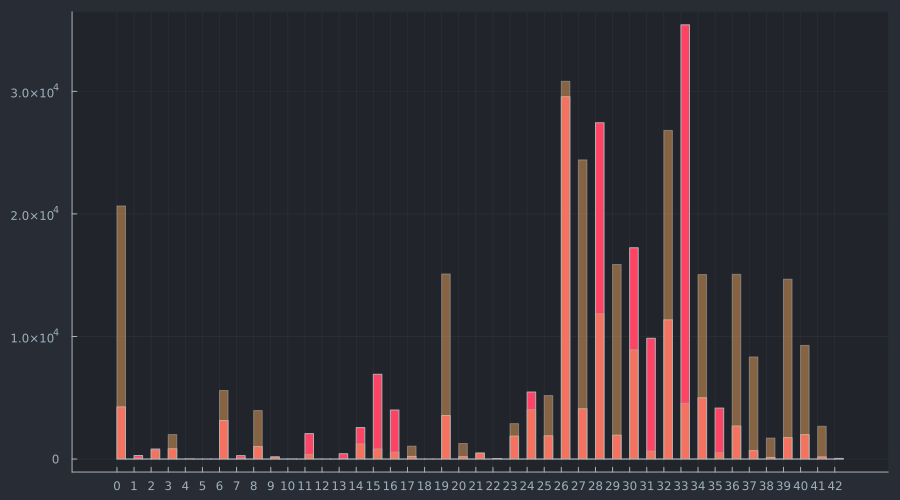

In [17]:
temp = @subset dft :class .== 33 
histogram( temp.nextclass, xticks = 0:1:42, leg = false, size = (900,500) )
temp = @subset dft :class .== 32 
histogram!( temp.nextclass, xticks = 0:1:42, leg = false, size = (900,500), alpha = 0.5 )

# OLD

In [2]:
# Load in processed deck size data
root = "data/processed/sc_counts_no_mid/"
fl = filter( !contains(".DS"), readdir(root) )
df = DataFrame()
for i in fl append!( df, @transform CSV.read( joinpath(root, i), dateformat="yyyy-mm-dd", DataFrame ) :region = split(i, "_")[3] ) end
replace!( df.region, "n" => "npacific" , "africa" => "salantic" )

df = @chain df begin 
    @by [:region, :date] :day_sum=sum(:members) :day_mean=mean(:members) :day_max=maximum(:members) :day_med=median(:members) :day_num=size(:members)[1]
    @transform :year=year.(:date) :month=month.(:date) :dayofyear=dayofyear.(:date)
    @rsubset :month in Set( 1:12 )
    @orderby :date
end;

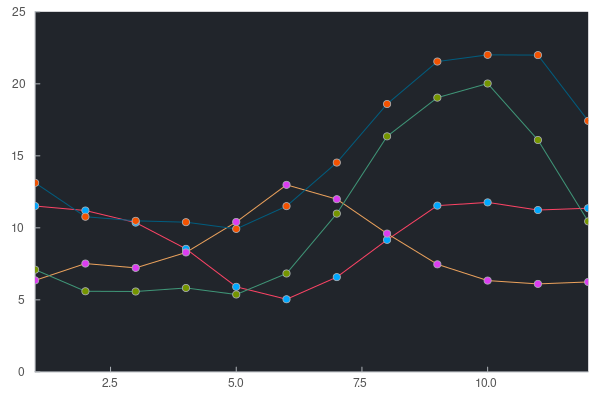

In [4]:
dfm = @chain df begin 
    @by [:region, :month] :mean_tot_sc=mean(:day_sum) :mean_patch_size=mean(:day_mean) :mean_max_size=mean(:day_max)
    @orderby :month
end

plot( dfm.month, dfm.mean_tot_sc./2025 .* 100, group =dfm.region, fontfamily="Helvetica", grid=false, 
        xlim=(1,12), ylim=(0,25), background_color=:false, face_color=:false, leg =:false)

#scatter!( dfm.month, dfm.mean_tot_sc./2025 .* 100, group = dfm.region, fill=:false)
#png("figures/test.png")

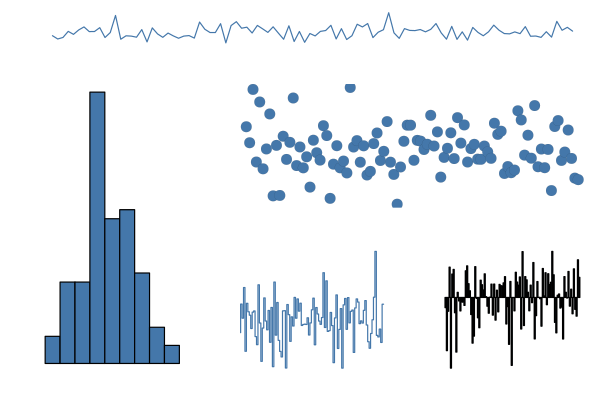

In [31]:
plot(layout = @layout([a{0.1h}; b{0.3w} [c; d e]]), randn(100, 5), 
    t = [:line :histogram :scatter :steppre :bar], leg = false, border = :none)